# Optimisation

This tutorial introduces the optimisation routine in TOAD. 


In [ ]:
# Prerequisites
from toad import TOAD
from sklearn.cluster import HDBSCAN  # type: ignore
from toad.shifts import ASDETECT
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

In [6]:
# start by initiating TOAD
td = TOAD("test_data/garbe_2020_antarctica.nc")
td.data = td.data.coarsen(x=3, y=3, time=3, boundary="trim").reduce(np.mean)

## Basic optimisation

with `td.optimiste(var)` you can run a basic optimisation which optimises three paramters for the clustering process, namely min_cluster_size, shift_treshold and time_scale_param. The default clustering parameters to optimize are defined in `default_cluster_param_ranges` within `optimisation.__init__.py`.

In [7]:
td.optimise(var="thk")

  0%|          | 0/50 [00:00<?, ?it/s]

Completed 50 trials in 83.11 seconds
Best trial: 46 with score 1.1344
Best params: {'min_cluster_size': 22, 'shift_threshold': 0.8438335282710483, 'time_scale_factor': 0.8841221878018628}
Identified 27 clusters


Once the optimisation finished, the best solution is saved in the TOAD instance and we can plot the results:

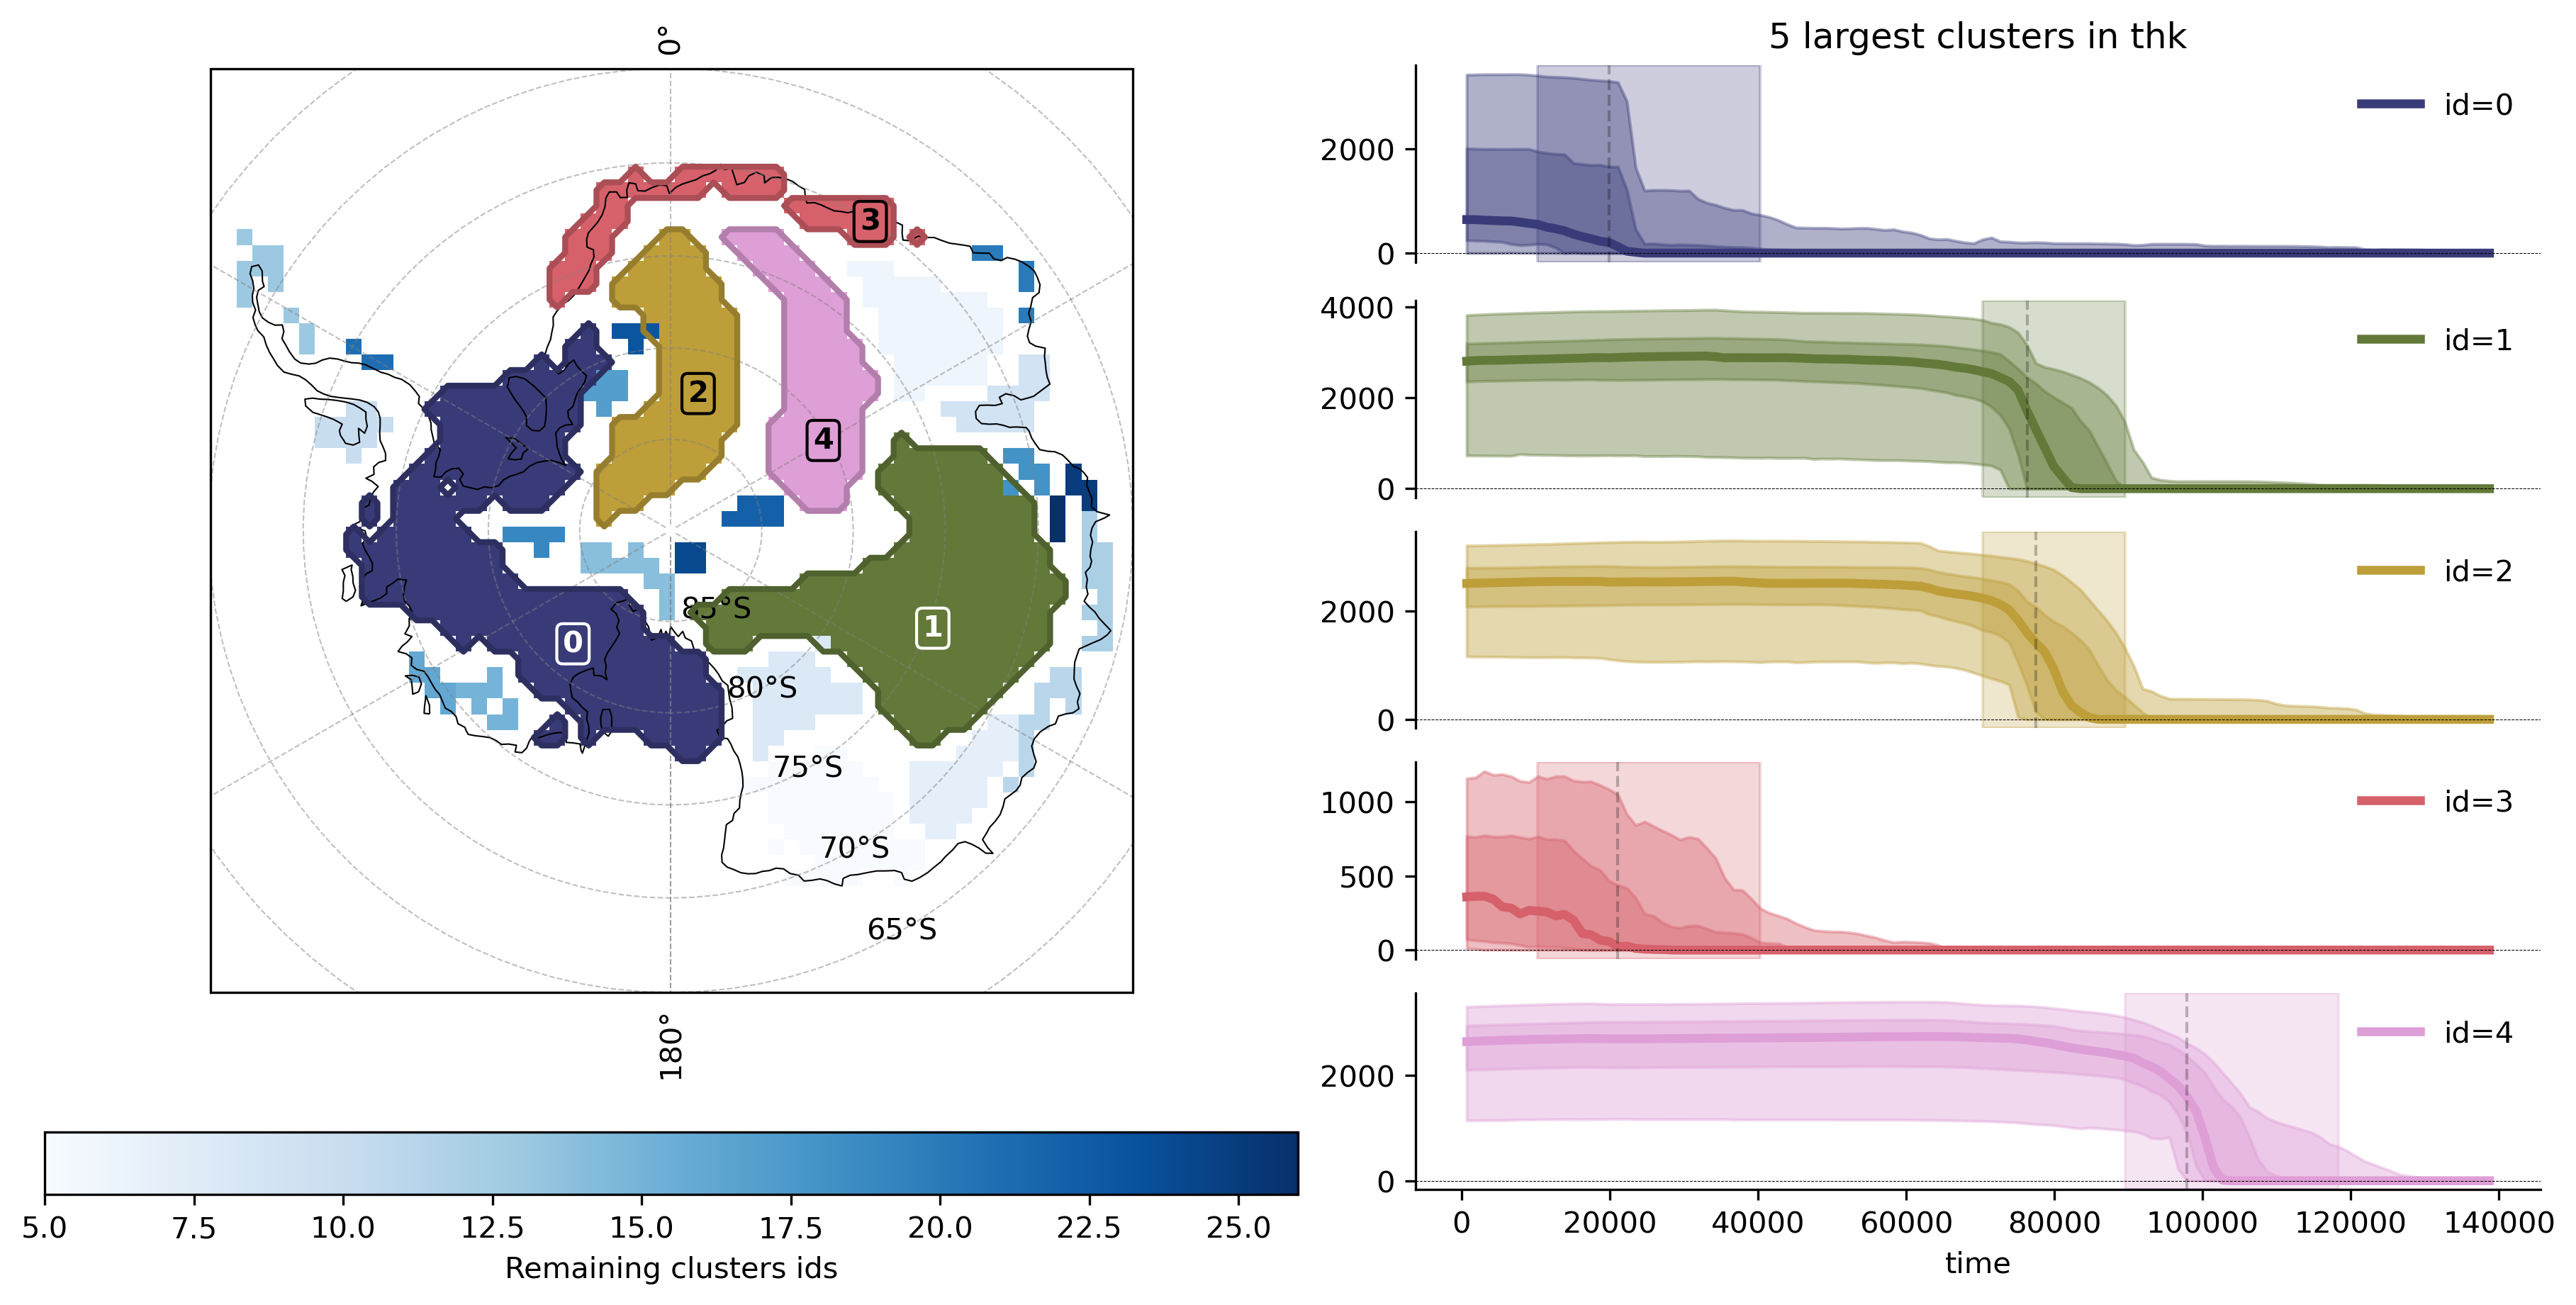

In [8]:
td.plotter().cluster_overview("thk", projection="south_pole");

## Defining param ranges and methods

The `optimise()` function provides fine-grained control over the optimization process:

- Choose which shift detection and clustering methods to use
- Customize parameter ranges for both methods:
  - Set ranges to explore (e.g. min_cluster_size=(8, 25))
  - Fix parameters to specific values (e.g. shift_threshold=0.9)
- Select an objective function from several built-in options (see docstring).
- Configure other optimization settings like number of trials

The example below demonstrates these capabilities.

In [9]:
td.optimise(
    shifts_method=ASDETECT,
    cluster_method=HDBSCAN,
    shifts_param_ranges={
        "lmax": (10, 30),
    },
    cluster_param_ranges={
        "min_cluster_size": (8, 25),
        "time_scale_factor": (0.5, 1.5),
        "shift_threshold": 0.9,  # or set a fixed value
    },
    objective="mean_spatial_autocorrelation",
    var="thk",
    n_trials=25,
)

  0%|          | 0/25 [00:00<?, ?it/s]

Completed 25 trials in 99.94 seconds
Best trial: 0 with score 0.8605
Best params: {'lmax': 30, 'min_cluster_size': 15, 'time_scale_factor': 1.1920022634311804}
Identified 28 clusters


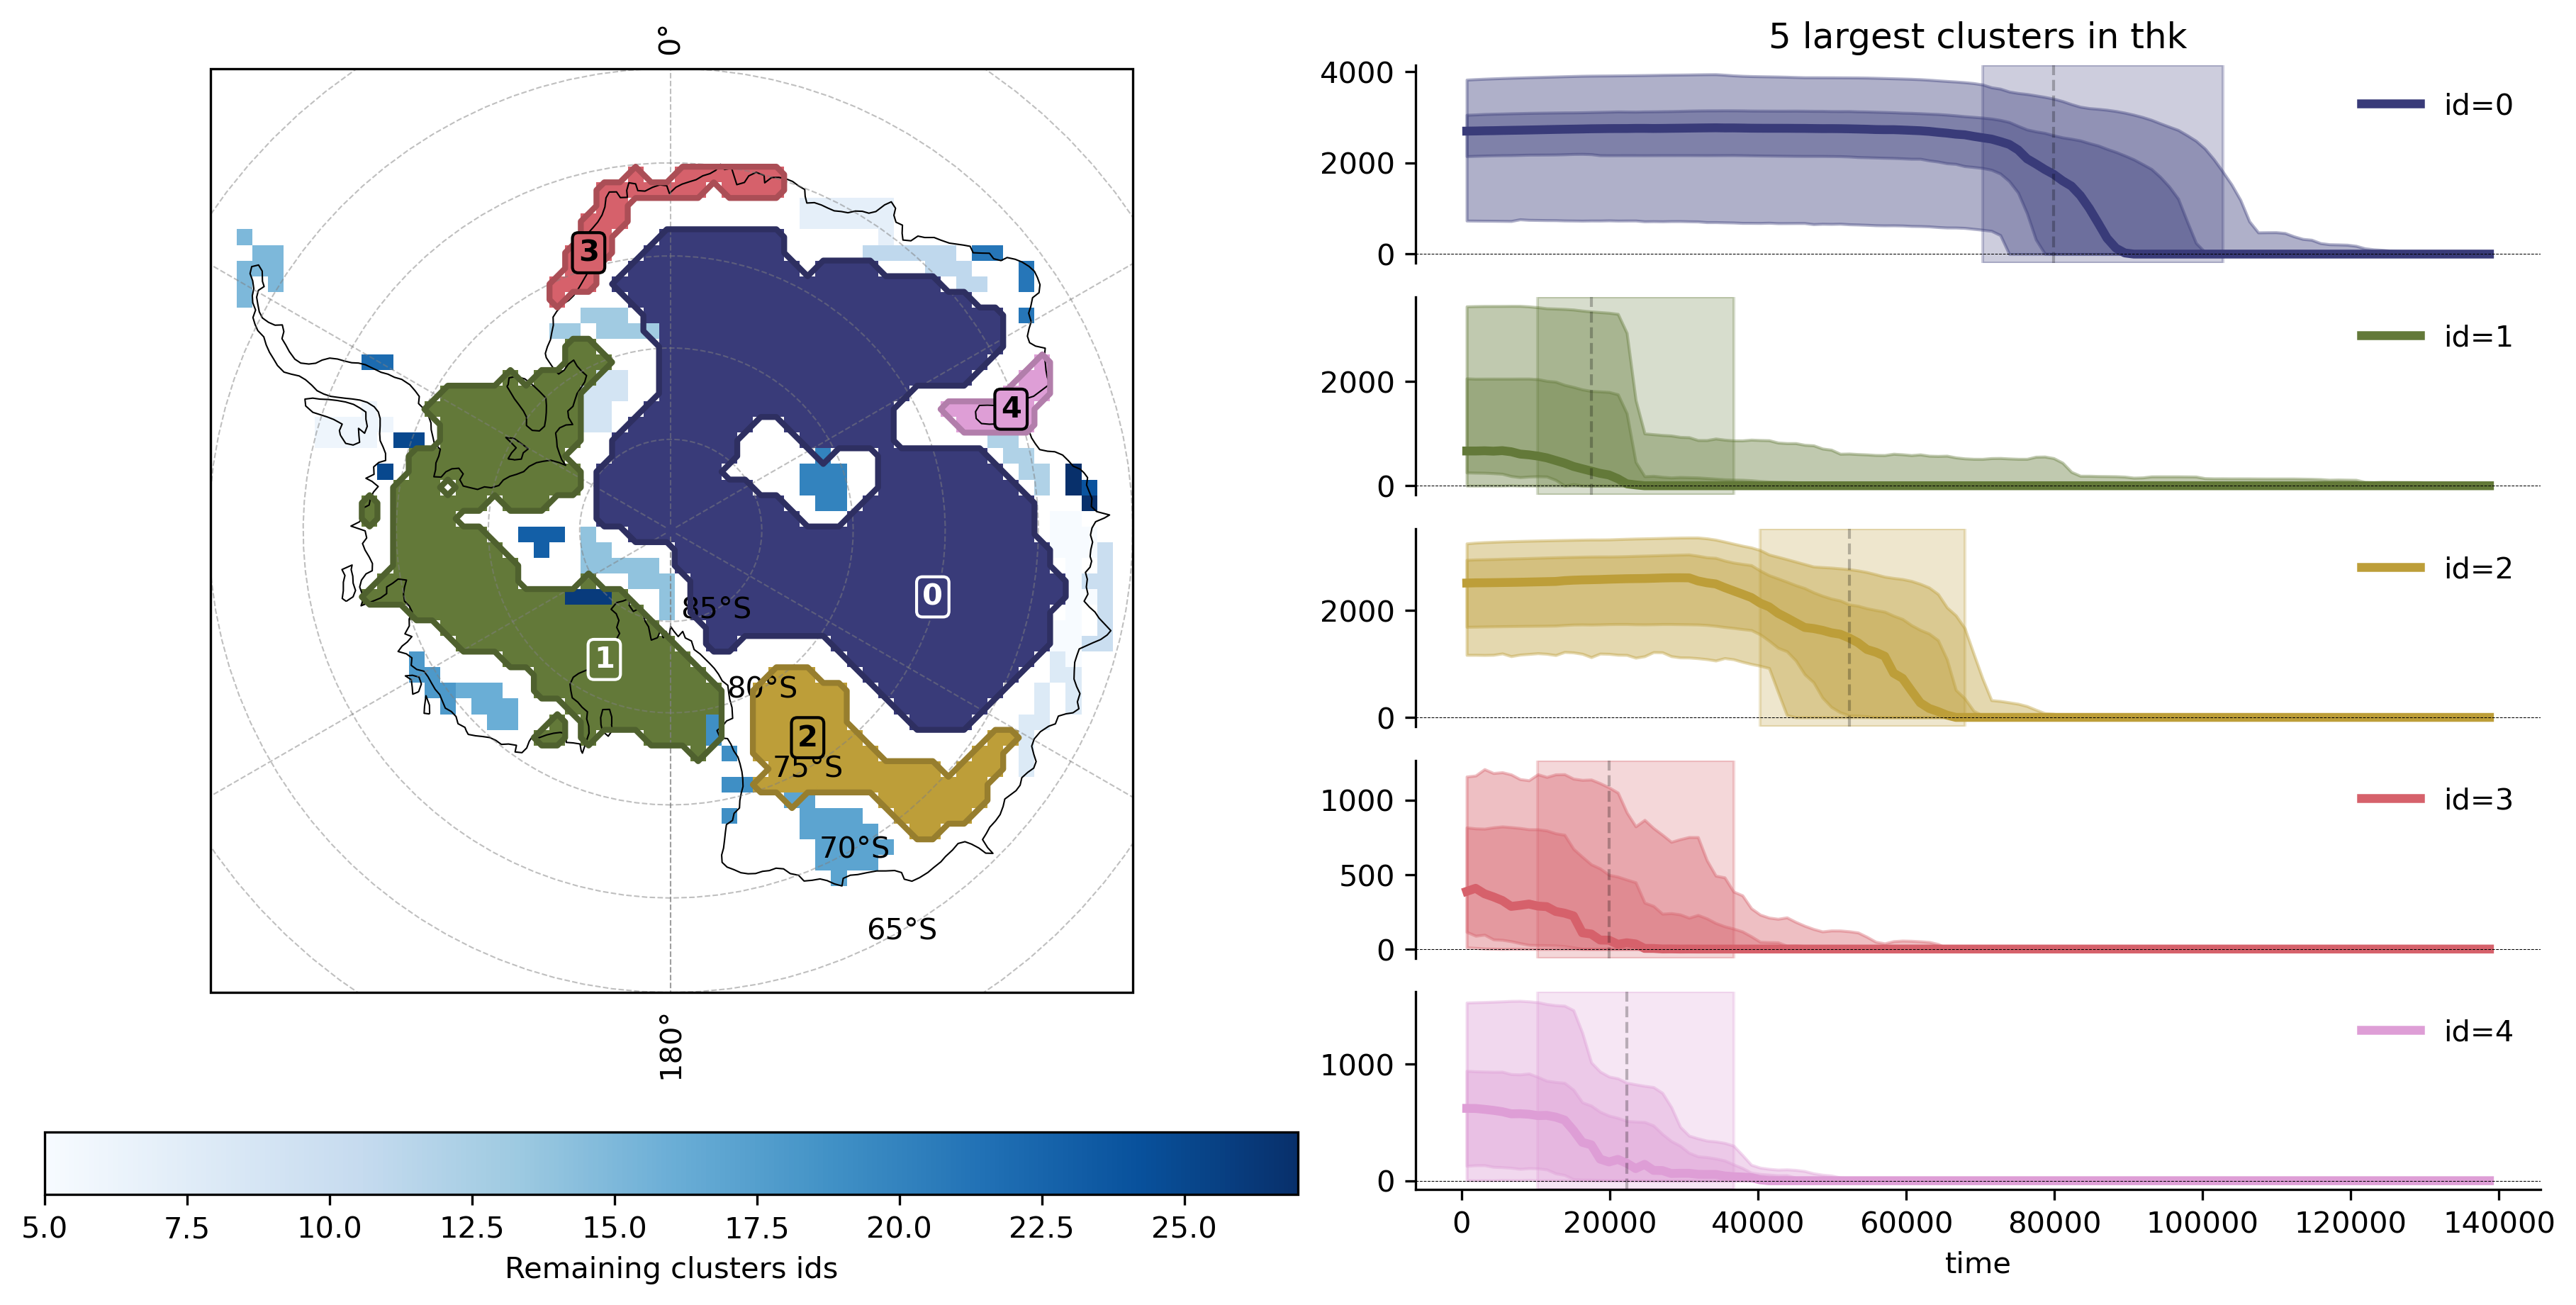

In [10]:
td.plotter().cluster_overview("thk", projection="south_pole");

## Defining your own optimisation function

You can also define your own optimisation cost function: 


In [ ]:
# Define objective function
def custom_objective_func(td, var) -> float:
    """In here you have access to the TOAD object after each computation and the variable name"""

    # Example of how one could compute a score using the cluster_stats object
    cluster_ids = td.get_cluster_ids(var)
    score1 = td.cluster_stats(var).general.aggregate_cluster_scores(
        cluster_ids=cluster_ids[:2],
        score_method="score_spatial_autocorrelation",
        aggregation="median",
    )

    # must return a float
    return float(score1)


# Run optimisation
td.optimise(
    shifts_method=ASDETECT,
    cluster_method=HDBSCAN,
    cluster_param_ranges={
        "min_cluster_size": (8, 25),
    },
    objective=custom_objective_func,  # pass the function to the optimisation routine
    direction="maximize",  # higher is better so set direction to "maximize"
    var="thk",
    n_trials=10,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Completed 10 trials in 17.68 seconds
Best trial: 2 with score 0.8129
Best params: {'min_cluster_size': 25}
Identified 19 clusters


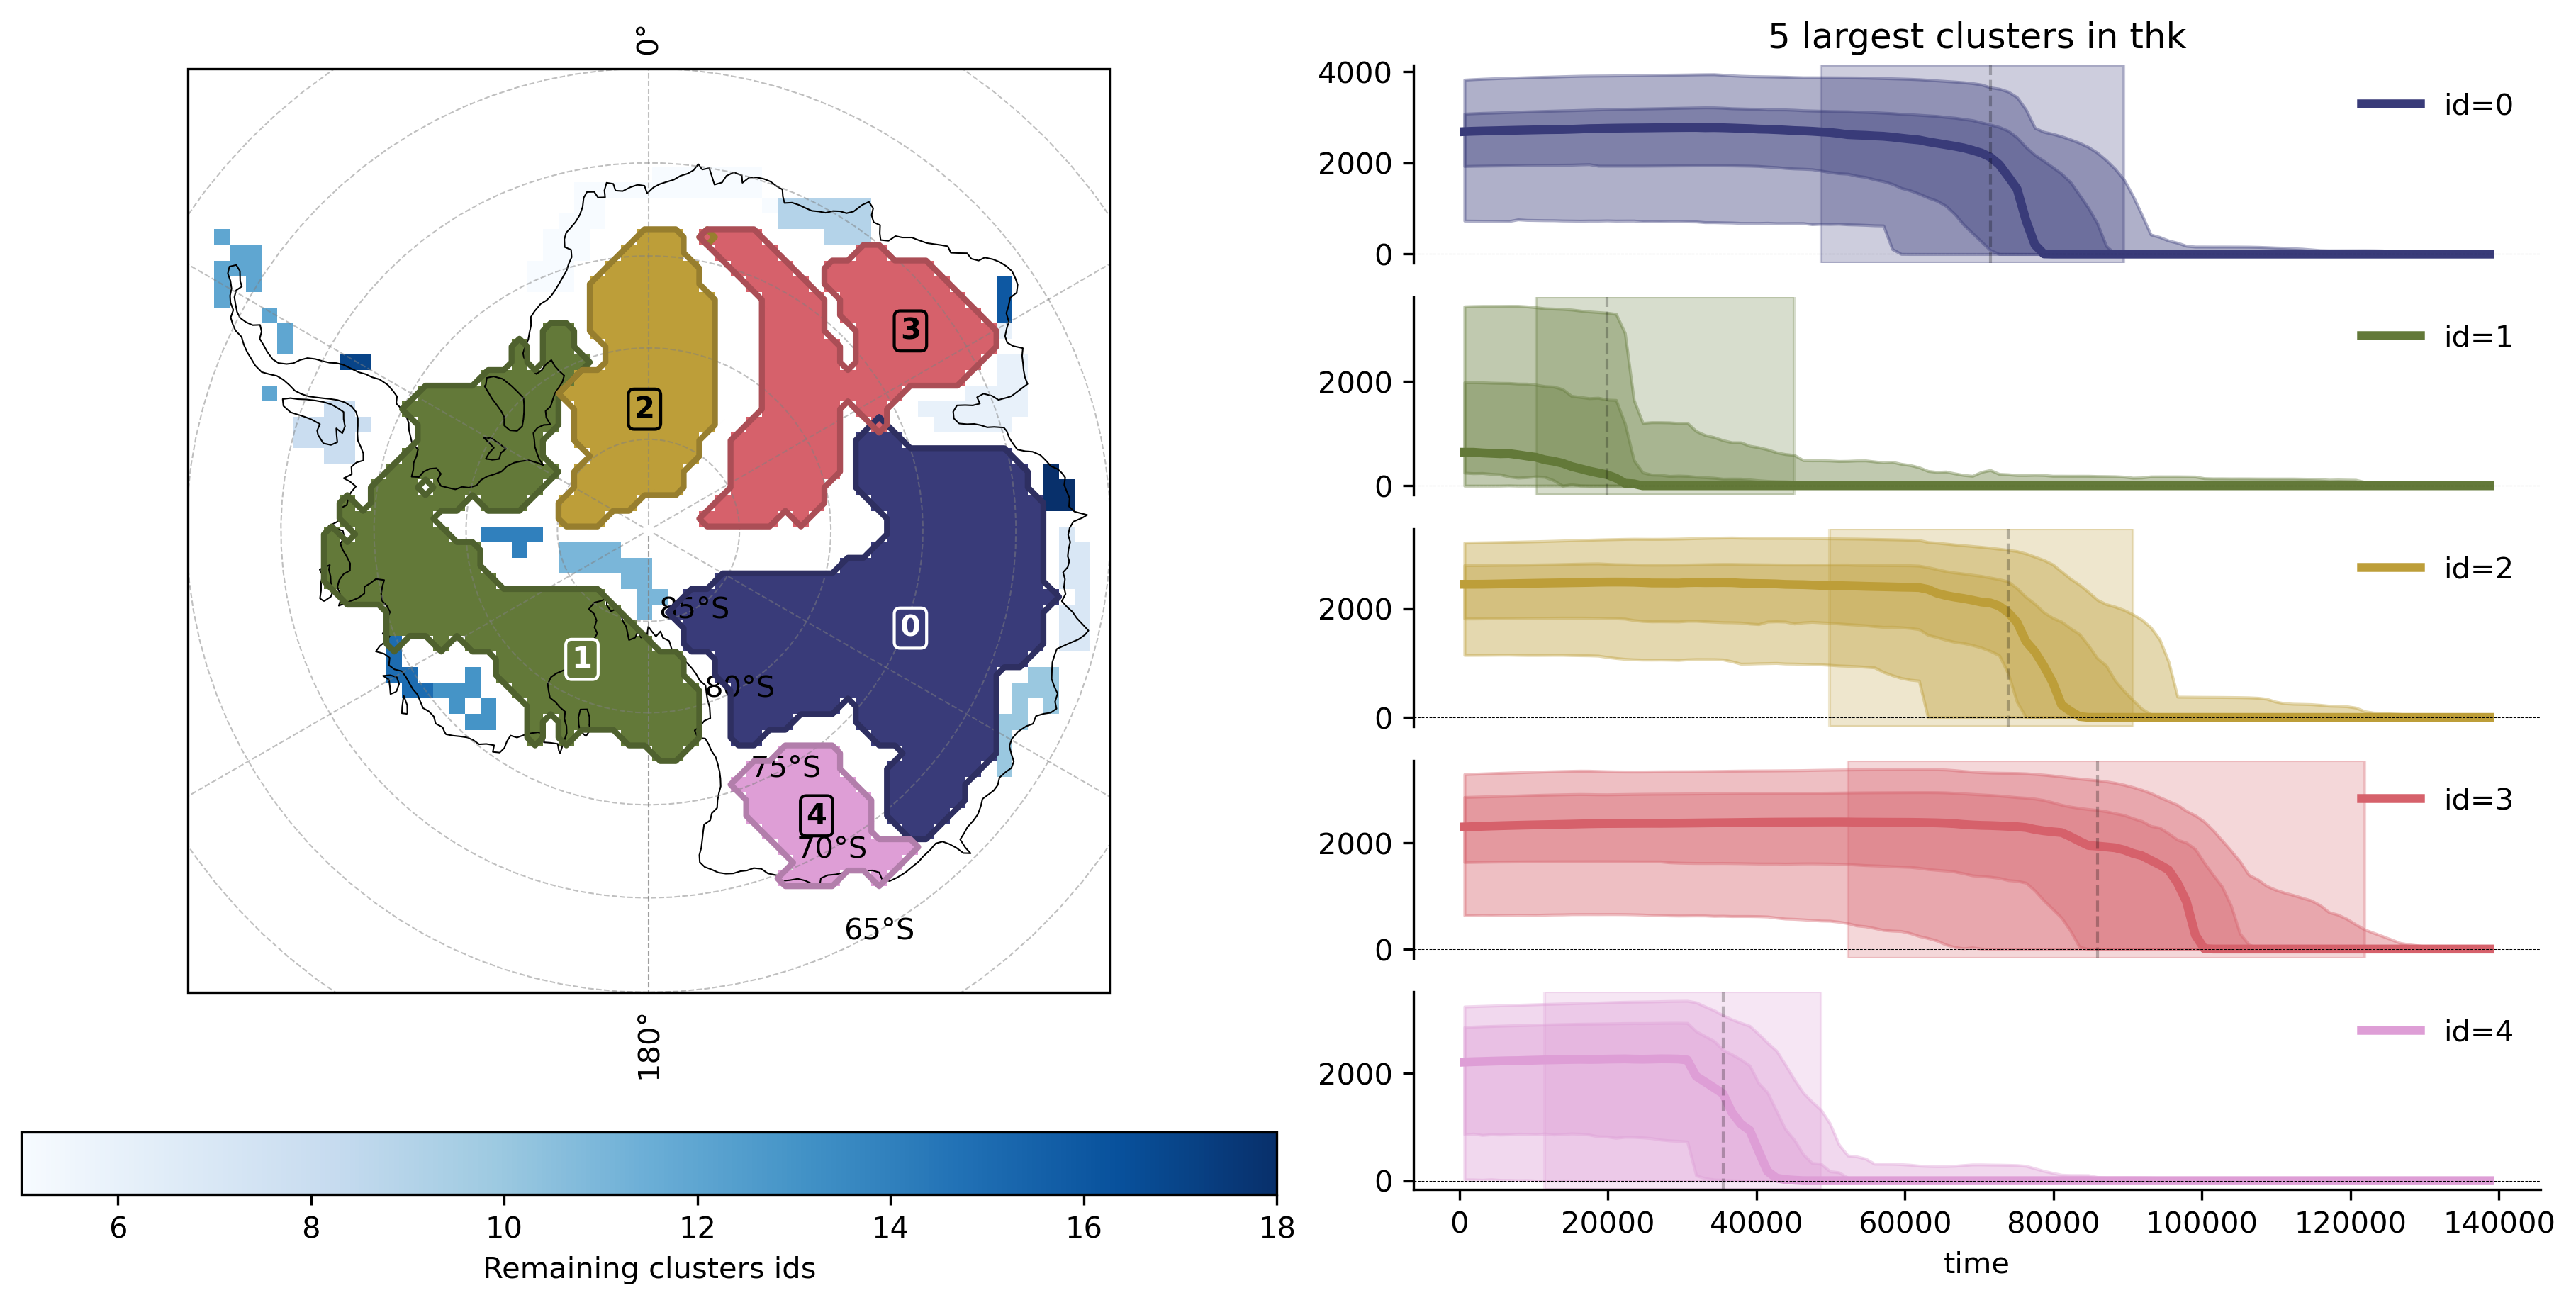

In [12]:
td.plotter().cluster_overview("thk", projection="south_pole");